# Map and Block Processor

This notebook processes a map file and block definition file to create a final tile map.

**Input:**
- `Map-Level1`: 42×24 grid of block IDs (1008 bytes)
- `blocks`: Block definitions, each block is 16 bytes (4×4 tiles)

**Output:**
- Final tile map: 168×96 (42×4 by 24×4) in hex format

In [ ]:
import numpy as np
import struct

# File paths - update these if needed
MAP_FILE = 'Map-Level-Second'
BLOCKS_FILE = 'blocks'
OUTPUT_FILE = 'tilemap_output.hex'

# Map dimensions in blocks
MAP_WIDTH_BLOCKS = 24
MAP_HEIGHT_BLOCKS = 42

# Block dimensions in tiles
BLOCK_WIDTH = 4
BLOCK_HEIGHT = 4
BLOCK_SIZE = BLOCK_WIDTH * BLOCK_HEIGHT  # 16 bytes per block

# Final map dimensions in tiles
FINAL_WIDTH = MAP_WIDTH_BLOCKS * BLOCK_WIDTH   # 96
FINAL_HEIGHT = MAP_HEIGHT_BLOCKS * BLOCK_HEIGHT # 168

In [28]:
# Read the map file
with open(MAP_FILE, 'rb') as f:
    map_data = f.read()

print(f"Map file size: {len(map_data)} bytes")
print(f"Expected: {MAP_WIDTH_BLOCKS * MAP_HEIGHT_BLOCKS} bytes")
assert len(map_data) == MAP_WIDTH_BLOCKS * MAP_HEIGHT_BLOCKS, "Map file size mismatch!"

# Convert to numpy array for easier manipulation
map_blocks = np.frombuffer(map_data, dtype=np.uint8).reshape(MAP_HEIGHT_BLOCKS, MAP_WIDTH_BLOCKS)
print(f"\nMap shape: {map_blocks.shape}")
print(f"\nFirst few block IDs:")
print(map_blocks[:5, :10])

Map file size: 1008 bytes
Expected: 1008 bytes

Map shape: (42, 24)

First few block IDs:
[[  5   5   5   5   5   5   5   5   5   5]
 [  5  30   0  51   5  69   4   3  96 255]
 [  5  30 255   0   5  56   4   3  77 255]
 [  5   1   1  58   7  57   4   3  76 255]
 [  5 114 255 255   4  58   7   3  76 255]]


In [29]:
# Read the blocks file
with open(BLOCKS_FILE, 'rb') as f:
    blocks_data = f.read()

print(f"Blocks file size: {len(blocks_data)} bytes")
print(f"Number of block definitions: {len(blocks_data) // BLOCK_SIZE}")

# Parse blocks into a dictionary
blocks = {}
num_blocks = len(blocks_data) // BLOCK_SIZE

for block_id in range(num_blocks):
    offset = block_id * BLOCK_SIZE
    block_bytes = blocks_data[offset:offset + BLOCK_SIZE]
    # Reshape into 4x4 grid (row-major order)
    blocks[block_id] = np.frombuffer(block_bytes, dtype=np.uint8).reshape(BLOCK_HEIGHT, BLOCK_WIDTH)

print(f"\nExample: Block 0x05 (ID 5):")
print(blocks[5])
print(f"\nExample: Block 0x1A (ID 26):")
print(blocks[26])

Blocks file size: 2048 bytes
Number of block definitions: 128

Example: Block 0x05 (ID 5):
[[1 1 1 1]
 [2 2 2 2]
 [1 1 1 1]
 [2 2 2 2]]

Example: Block 0x1A (ID 26):
[[12 13 12 13]
 [14 15 14 15]
 [12 13 12 13]
 [14 15 14 15]]


In [30]:
# Create the final tile map
tilemap = np.zeros((FINAL_HEIGHT, FINAL_WIDTH), dtype=np.uint8)

print(f"Building final tilemap of size {FINAL_HEIGHT}×{FINAL_WIDTH}...")

# Process each block in the map
for row in range(MAP_HEIGHT_BLOCKS):
    for col in range(MAP_WIDTH_BLOCKS):
        block_id = map_blocks[row, col]
        
        # Get the block definition
        if block_id in blocks:
            block = blocks[block_id]
        else:
            # If block ID not found, use zeros
            print(f"Warning: Block ID {block_id} not found, using zeros")
            block = np.zeros((BLOCK_HEIGHT, BLOCK_WIDTH), dtype=np.uint8)
        
        # Calculate position in final tilemap
        tile_row = row * BLOCK_HEIGHT
        tile_col = col * BLOCK_WIDTH
        
        # Copy the 4×4 block into the tilemap
        tilemap[tile_row:tile_row + BLOCK_HEIGHT, tile_col:tile_col + BLOCK_WIDTH] = block

print(f"Tilemap complete! Shape: {tilemap.shape}")
print(f"\nFirst 10×10 tiles of the final map:")
print(tilemap[:10, :10])

Building final tilemap of size 168×96...
Tilemap complete! Shape: (168, 96)

First 10×10 tiles of the final map:
[[ 1  1  1  1  1  1  1  1  1  1]
 [ 2  2  2  2  2  2  2  2  2  2]
 [ 1  1  1  1  1  1  1  1  1  1]
 [ 2  2  2  2  2  2  2  2  2  2]
 [ 1  1  1  1 33  0  0 34  0  0]
 [ 2  2  2  2 35 36  0 34  0  0]
 [ 1  1  1  1 37 38  0 34  0  0]
 [ 2  2  2  2  2  2  2  2  0  0]
 [ 1  1  1  1 33  0  0 34  0  0]
 [ 2  2  2  2 35 36  0 34  0  0]]


In [31]:
# Write the output as a hex file
# Format: each row on a new line, with hex values separated by spaces

with open(OUTPUT_FILE, 'w') as f:
    for row in range(FINAL_HEIGHT):
        hex_row = ' '.join(f'{tile:02x}' for tile in tilemap[row])
        f.write(hex_row + '\n')

print(f"Output written to {OUTPUT_FILE}")
print(f"Total rows: {FINAL_HEIGHT}")
print(f"Total columns: {FINAL_WIDTH}")
print(f"Total tiles: {FINAL_HEIGHT * FINAL_WIDTH}")

Output written to tilemap_output.hex
Total rows: 168
Total columns: 96
Total tiles: 16128


In [32]:
# Optional: Save as binary file as well
BINARY_OUTPUT = 'tilemap_output.bin'

with open(BINARY_OUTPUT, 'wb') as f:
    tilemap.tofile(f)

print(f"Binary output written to {BINARY_OUTPUT}")
print(f"File size: {FINAL_HEIGHT * FINAL_WIDTH} bytes")

Binary output written to tilemap_output.bin
File size: 16128 bytes


In [33]:
# Verification: Show statistics
print("=== Tilemap Statistics ===")
print(f"Unique tiles used: {len(np.unique(tilemap))}")
print(f"Min tile value: 0x{tilemap.min():02x}")
print(f"Max tile value: 0x{tilemap.max():02x}")
print(f"\nMost common tiles:")

unique, counts = np.unique(tilemap, return_counts=True)
tile_counts = sorted(zip(unique, counts), key=lambda x: x[1], reverse=True)[:10]

for tile_id, count in tile_counts:
    percentage = (count / tilemap.size) * 100
    print(f"  Tile 0x{tile_id:02x}: {count:5d} times ({percentage:5.2f}%)")

=== Tilemap Statistics ===
Unique tiles used: 94
Min tile value: 0x00
Max tile value: 0x7f

Most common tiles:
  Tile 0x00:  7930 times (49.17%)
  Tile 0x02:  2759 times (17.11%)
  Tile 0x01:  2727 times (16.91%)
  Tile 0x1a:   225 times ( 1.40%)
  Tile 0x60:   206 times ( 1.28%)
  Tile 0x76:   174 times ( 1.08%)
  Tile 0x77:   174 times ( 1.08%)
  Tile 0x0c:   134 times ( 0.83%)
  Tile 0x0d:   134 times ( 0.83%)
  Tile 0x0e:   134 times ( 0.83%)


## Visualization (Optional)

You can visualize the tilemap if you want to see it as an image:

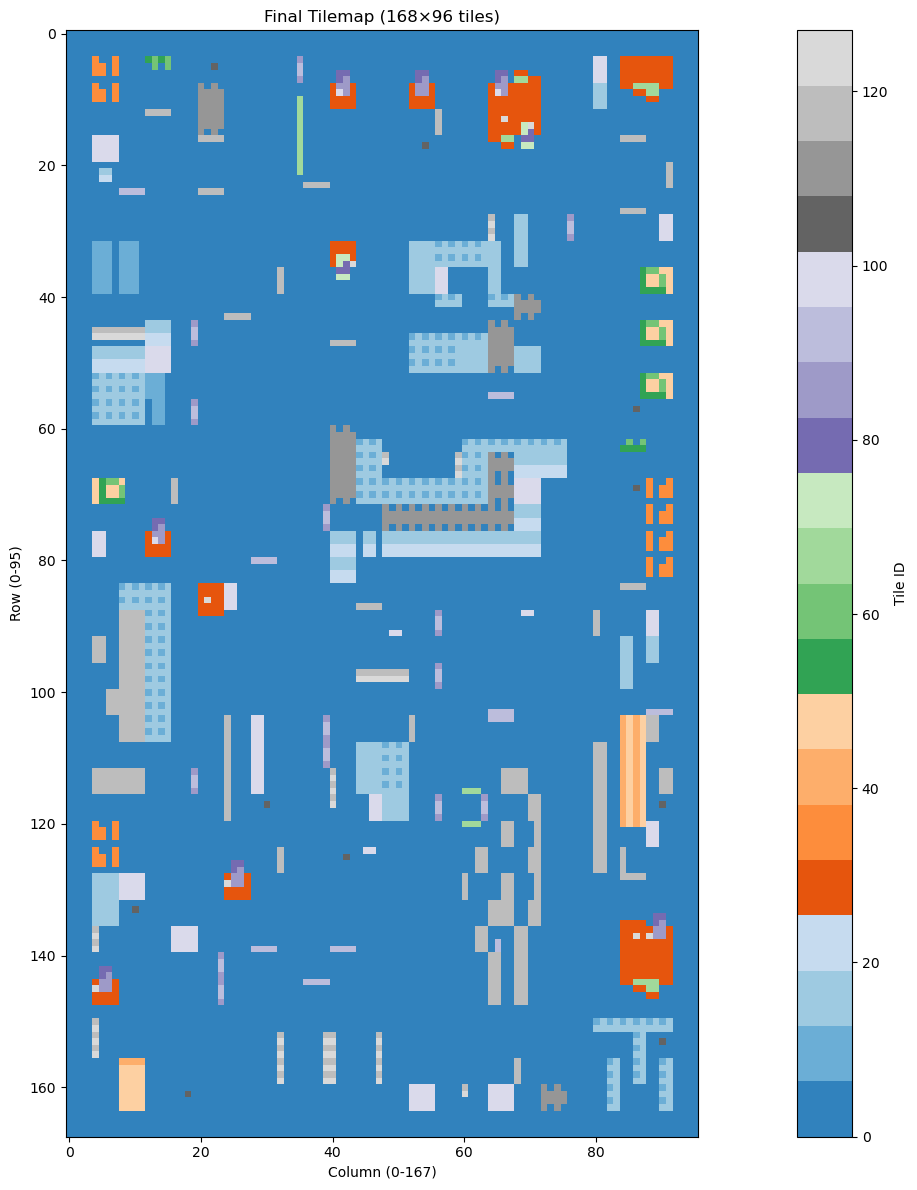

Visualization saved as tilemap_visualization.png


In [34]:
# Optional: Visualize the tilemap
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 12))
plt.imshow(tilemap, cmap='tab20c', interpolation='nearest')
plt.title('Final Tilemap (168×96 tiles)')
plt.colorbar(label='Tile ID')
plt.xlabel('Column (0-167)')
plt.ylabel('Row (0-95)')
plt.tight_layout()
plt.savefig('tilemap_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualization saved as tilemap_visualization.png")